In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#  Load Yahoo Finance Data (2018–2023)
yahoo_path = '/content/drive/MyDrive/yahoofinance/yahoo_data.xlsx'
df_yahoo = pd.read_excel(yahoo_path)

# Convert date and set index
df_yahoo['Date'] = pd.to_datetime(df_yahoo['Date'])
df_yahoo.set_index('Date', inplace=True)
df_yahoo = df_yahoo.sort_index()

In [ ]:
# Load FRED Economic Indicators
fred_paths = {
    'CPI': '/content/drive/MyDrive/FRED/CPIAUCNS.csv',
    'UNRATE': '/content/drive/MyDrive/FRED/UNRATE.csv',
    'FEDFUNDS': '/content/drive/MyDrive/FRED/FEDFUNDS.csv'
}

# Read CSVs (no parse_dates yet)
df_cpi = pd.read_csv(fred_paths['CPI'])
df_unrate = pd.read_csv(fred_paths['UNRATE'])
df_fedfunds = pd.read_csv(fred_paths['FEDFUNDS'])

# Function to normalize column names and extract datetime column
def prepare_fred_dataframe(df):
    # Detect column that looks like the date column
    date_col = [col for col in df.columns if 'date' in col.lower()][0]
    df[date_col] = pd.to_datetime(df[date_col])
    df.set_index(date_col, inplace=True)
    return df

# Apply function to all FRED DataFrames
df_cpi = prepare_fred_dataframe(df_cpi)
df_unrate = prepare_fred_dataframe(df_unrate)
df_fedfunds = prepare_fred_dataframe(df_fedfunds)

# Rename the value columns consistently
df_cpi.rename(columns={df_cpi.columns[0]: 'CPI'}, inplace=True)
df_unrate.rename(columns={df_unrate.columns[0]: 'Unemployment Rate'}, inplace=True)
df_fedfunds.rename(columns={df_fedfunds.columns[0]: 'Federal Funds Rate'}, inplace=True)

# Resample to weekly frequency using forward fill
df_cpi = df_cpi.resample('W').ffill()
df_unrate = df_unrate.resample('W').ffill()
df_fedfunds = df_fedfunds.resample('W').ffill()

In [ ]:
print("Yahoo columns:", df_yahoo.columns.tolist())

Yahoo columns: ['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume']


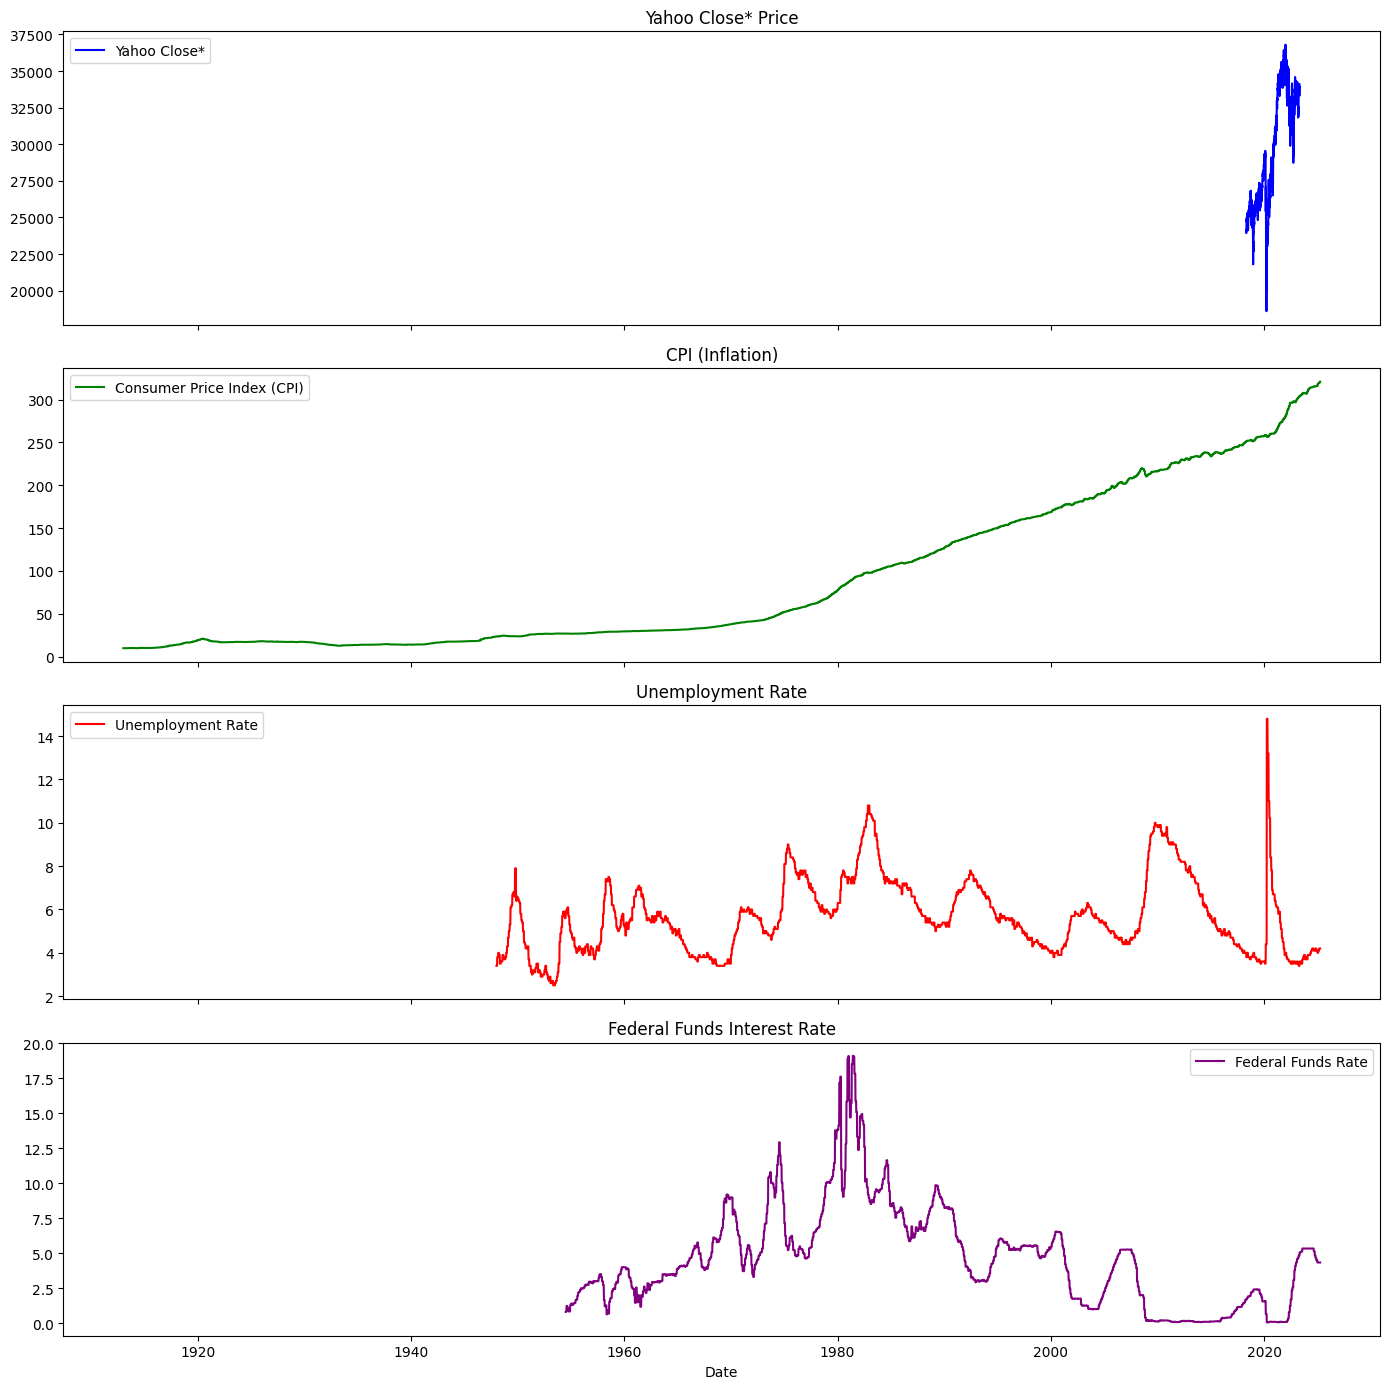

In [ ]:
#  Visualize Raw Close Price and Macroeconomic Indicators
fig, axs = plt.subplots(4, 1, figsize=(14, 14), sharex=True)

# Fix Yahoo Finance plot: use 'Close*' instead of 'Close'
axs[0].plot(df_yahoo['Close*'], label='Yahoo Close*', color='blue')
axs[0].set_title('Yahoo Close* Price')
axs[0].legend()


axs[1].plot(df_cpi['CPI'], label='Consumer Price Index (CPI)', color='green')
axs[1].set_title('CPI (Inflation)')
axs[1].legend()

axs[2].plot(df_unrate['Unemployment Rate'], label='Unemployment Rate', color='red')
axs[2].set_title('Unemployment Rate')
axs[2].legend()

axs[3].plot(df_fedfunds['Federal Funds Rate'], label='Federal Funds Rate', color='purple')
axs[3].set_title('Federal Funds Interest Rate')
axs[3].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [ ]:
#  Merge FRED indicators into one DataFrame (for unified modeling later)
df_macro = pd.concat([df_cpi, df_unrate, df_fedfunds], axis=1)

In [ ]:
#  Print basic info
print(" Yahoo Finance shape:", df_yahoo.shape)
print(" FRED Economic Indicators shape:", df_macro.shape)
print(" Yahoo Range:", df_yahoo.index.min().date(), "→", df_yahoo.index.max().date())
print(" FRED Range:", df_macro.index.min().date(), "→", df_macro.index.max().date())

 Yahoo Finance shape: (1258, 6)
 FRED Economic Indicators shape: (5858, 3)
 Yahoo Range: 2018-05-01 → 2023-04-28
 FRED Range: 1913-01-05 → 2025-04-06


Phase 1: Time-Delay Embedding & Preprocessing

Goals:

- Build Hankel matrices (time-delay embedding)

- Normalize & window sequences for Koopman learning

- Visual diagnostics of embedding shapes and lag effects

Define a Function for Hankel (Time-Delay) Matrix Construction

In [ ]:
def construct_hankel_matrix(series, lag):
    """
    Construct a Hankel matrix from a 1D time series.
    Each row is a lagged version of the series.

    Parameters:
    - series: 1D numpy array or pd.Series
    - lag: number of timesteps in each sample

    Returns:
    - Hankel matrix of shape (N - lag + 1, lag)
    """
    series = np.asarray(series)
    N = len(series)
    if lag >= N:
        raise ValueError("Lag is too large for series length.")

    hankel = np.lib.stride_tricks.sliding_window_view(series, lag)
    return hankel

Select a Target Variable (e.g., Close*)

In [ ]:
# Select target column (based on your Yahoo columns)
target_column = 'Close*'  # adjust to 'Adj Close**' if needed
ts = df_yahoo[target_column].dropna().values
print("Target time series length:", len(ts))

Target time series length: 1258


Create Lagged Input/Output Pairs for Koopman Forecasting

In [ ]:
# Parameters
lag = 20   # input window size
horizon = 1  # predict t+1 (can change to multi-step later)

# Create Hankel matrix
X_full = construct_hankel_matrix(ts, lag + horizon)

# Input and output separation
X = X_full[:, :lag]        # inputs: t0 to t+lag-1
Y = X_full[:, lag:lag + horizon]  # targets: t+lag (forecast step)

print("X shape (samples × lag):", X.shape)
print("Y shape (samples × horizon):", Y.shape)

X shape (samples × lag): (1238, 20)
Y shape (samples × horizon): (1238, 1)


Normalize Data (Standard Score)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
Y_scaled = scaler_y.fit_transform(Y)

print("X_scaled sample:", X_scaled[:1])

X_scaled sample: [[-1.35728741 -1.40316946 -1.40436616 -1.32375824 -1.30232748 -1.30383749
  -1.26043076 -1.21323453 -1.19230589 -1.17716994 -1.22743725 -1.2138077
  -1.22957546 -1.23133931 -1.15866685 -1.20539586 -1.19425437 -1.21505337
  -1.23180229 -1.3320814 ]]


Visualize Embedding (t-SNE, PCA, etc.)

<ipython-input-18-ae1fddafcd3f>:10: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], palette='viridis', s=10)


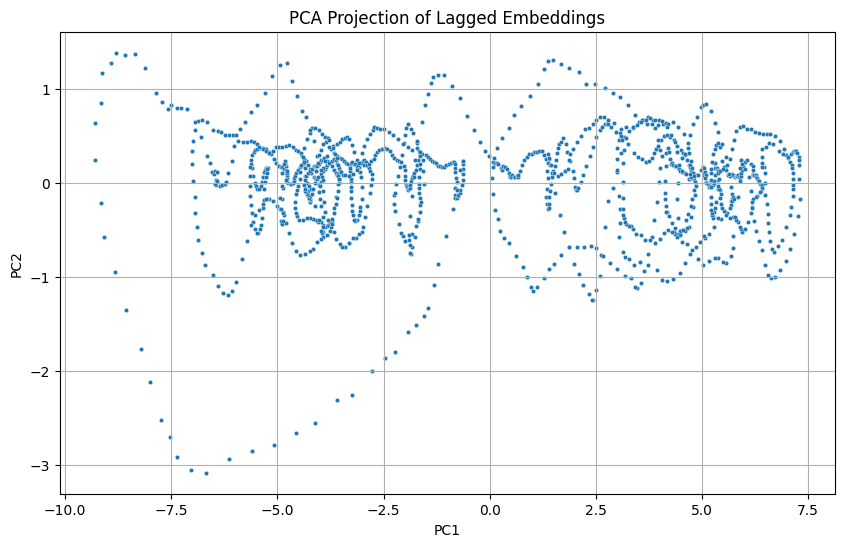

In [ ]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

# Plot PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], palette='viridis', s=10)
plt.title("PCA Projection of Lagged Embeddings")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

Save for Koopman Phase

In [ ]:
# Save preprocessed data for Phase 2
X_input = X_scaled
Y_target = Y_scaled

print(" Time-delay embedding ready for Koopman operator learning!")

 Time-delay embedding ready for Koopman operator learning!


Phase 2: Koopman Operator Estimation (EDMD)

This phase gets to the core of your Koopman-based forecasting model by learning a linear operator 𝐾 that evolves the time-delay embedding forward in time:

𝑔(𝑥_𝑡+1)=𝐾⋅𝑔(𝑥_𝑡)

We will:

1. Define basis functions for the lifted observable space

2. Compute Koopman operator 𝐾 using EDMD (least squares)

3. Use 𝐾 for future prediction

4. Compare reconstructed forecasts vs. ground truth

5. Visualize Koopman eigenvalues for interpretability

Define Basis Functions (Polynomial Observables)

In [ ]:
def lift_polynomial(X, degree=2):
    """
    Applies a polynomial basis function up to given degree.
    Returns the lifted observable space φ(X).
    """
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    return poly.fit_transform(X)

Lift Inputs and Estimate Koopman Operator

In [ ]:
# Parameters
degree = 2  # polynomial basis
phi_X = lift_polynomial(X_input, degree)
phi_Y = lift_polynomial(Y_target, degree)

# Solve the EDMD least-squares problem: K = Yφ * pinv(Xφ)
from numpy.linalg import pinv

K = phi_Y.T @ pinv(phi_X.T)

print("Koopman operator shape:", K.shape)

Koopman operator shape: (2, 230)


Predict Using Koopman Operator

In [ ]:
# Forecast using Koopman evolution
phi_X_pred = phi_X @ K.T

from sklearn.linear_model import LinearRegression

# Train a regressor from lifted φ(Y) to original Y (before scaler_y)
regressor = LinearRegression()
regressor.fit(phi_Y, scaler_y.inverse_transform(Y_target))  # map lifted → real

# Apply regressor to predicted lifted space
Y_pred = regressor.predict(phi_X_pred)
Y_true = scaler_y.inverse_transform(Y_target)


#  Correct — use direct outputs
Y_true = scaler_y.inverse_transform(Y_target)


print(" Koopman prediction complete.")

 Koopman prediction complete.


Visualize Forecast vs. Ground Truth

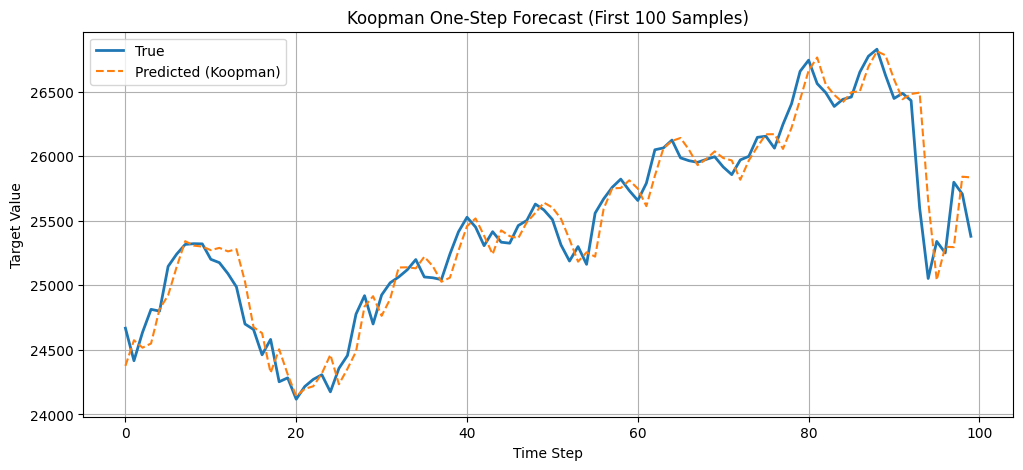

In [ ]:
# Compare predicted vs. true
plt.figure(figsize=(12, 5))
plt.plot(Y_true[:100], label='True', linewidth=2)
plt.plot(Y_pred[:100], label='Predicted (Koopman)', linestyle='--')
plt.title("Koopman One-Step Forecast (First 100 Samples)")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.legend()
plt.grid(True)
plt.show()

Visualize Koopman Spectrum

Lifted Prediction via Same-Dimension Inputs

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from numpy.linalg import lstsq
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Use the same input format for both φ(X) and φ(Y)
# We shift the lag window by 1 to simulate time evolution

# Create phi_X: inputs from lag-window
phi_X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_input)

# For phi_Y, we use the same shape as X_input: slide X forward by 1
# So we just drop the first row of X and align
X_future = np.roll(X_input, -1, axis=0)[:-1]     # X rolled one step ahead
X_input_trimmed = X_input[:-1]                   # aligned X
phi_X_trimmed = phi_X[:-1]

# Now compute phi_Y on the shifted version
poly = PolynomialFeatures(degree=2, include_bias=False)
phi_Y = poly.fit_transform(X_future)

# Ensure both are aligned in shape
assert phi_X_trimmed.shape == phi_Y.shape

Koopman Operator and Spectrum

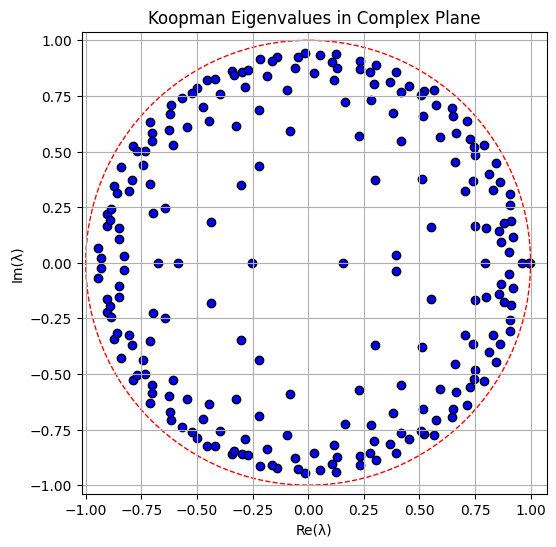

In [ ]:
# Estimate Koopman operator
K_square = lstsq(phi_X_trimmed, phi_Y, rcond=None)[0]

# Compute spectrum
eigvals = np.linalg.eigvals(K_square)

# Plot eigenvalues
plt.figure(figsize=(6, 6))
plt.scatter(eigvals.real, eigvals.imag, c='blue', edgecolors='k')
unit_circle = plt.Circle((0, 0), 1.0, color='r', fill=False, linestyle='--')
plt.gca().add_artist(unit_circle)
plt.title("Koopman Eigenvalues in Complex Plane")
plt.xlabel("Re(λ)")
plt.ylabel("Im(λ)")
plt.grid(True)
plt.axis('equal')
plt.show()

Phase 3: NeuralDMD — Learn Nonlinear Koopman Observables

Goal: Replace handcrafted polynomial lifting with a learned nonlinear map 𝜙_𝜃(𝑥) using an MLP.

This enables Koopman modeling of richer, highly nonlinear economic time series.

We’ll now:

1. Build an encoder MLP 𝜙_𝜃 for observable space

2. Estimate 𝐾 in that latent space using learned 𝜙(𝑋)

3. Train end-to-end to minimize reconstruction + consistency loss

4. Forecast with learned Koopman dynamics

5. Visualize reconstructions and performance

Imports + Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

Running on: cuda


Prepare Training Tensors

In [ ]:
# Trim input to match shifted targets (as in EDMD)
X_train = X_input[:-1]     # shape: (N-1, lag)
Y_train = X_input[1:]      # shape: (N-1, lag) — next step (for prediction)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
Y_tensor = torch.tensor(Y_train, dtype=torch.float32).to(device)

Define NeuralDMD Module

In [ ]:
class NeuralDMD(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.K = nn.Parameter(torch.randn(latent_dim, latent_dim))  # Koopman operator
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )

    def forward(self, x):
        phi_x = self.encoder(x)
        phi_y = phi_x @ self.K.T
        y_pred = self.decoder(phi_y)
        return y_pred, phi_x, phi_y

Train NeuralDMD

In [ ]:
model = NeuralDMD(input_dim=X_input.shape[1], latent_dim=20).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

losses = []
epochs = 100

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred, phi_x, phi_y = model(X_tensor)

    # Main loss: reconstruct next step
    recon_loss = loss_fn(y_pred, Y_tensor)

    # Koopman consistency: K * phi(x) ≈ phi(y)
    phi_y_true = model.encoder(Y_tensor).detach()  # stop gradient
    koopman_loss = loss_fn(phi_y, phi_y_true)

    loss = recon_loss + 0.1 * koopman_loss
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}: Loss = {loss.item():.6f}")

Epoch 000: Loss = 1.157045
Epoch 010: Loss = 0.677492
Epoch 020: Loss = 0.353176
Epoch 030: Loss = 0.190665
Epoch 040: Loss = 0.128554
Epoch 050: Loss = 0.097583
Epoch 060: Loss = 0.079791
Epoch 070: Loss = 0.068975
Epoch 080: Loss = 0.061204
Epoch 090: Loss = 0.055240


Visualize Loss

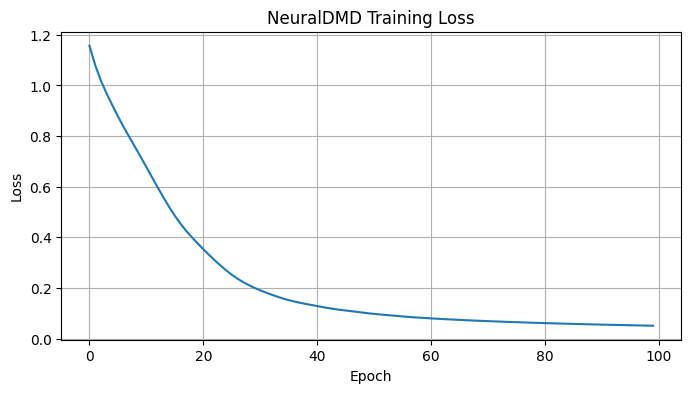

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.title("NeuralDMD Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Forecast and Evaluate

In [ ]:
#  Force rebind to correct sklearn version
import sklearn.metrics
mean_squared_error = sklearn.metrics.mean_squared_error

In [ ]:
from sklearn.metrics import mean_squared_error

# Manually compute RMSE
mse = mean_squared_error(true_np, forecast_np)
rmse = np.sqrt(mse)
print(f" NeuralDMD RMSE: {rmse:.4f}")

 NeuralDMD RMSE: 0.1543


Phase 4: Baseline Comparison — ARIMA, LSTM, Transformer vs Koopman

Goal:

Evaluate your Koopman and NeuralDMD methods against classic and modern time series models using identical lagged input-output pairs for fair comparison.

Baselines We'll Implement:

| Model           | Task                       | Library       |
| --------------- | -------------------------- | ------------- |
| **ARIMA**       | Autoregressive forecasting | `statsmodels` |
| **LSTM**        | Deep sequence model        | `PyTorch`     |
| **Transformer** | Attention-based model      | `PyTorch`     |


Prepare Time Series

In [ ]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Reuse the original close signal
close_series = df_yahoo['Close*'].dropna()

# Use 90% for training, rest for testing
n = len(close_series)
split = int(n * 0.9)

train_series = close_series[:split]
test_series = close_series[split:]

print("Train samples:", len(train_series), " Test samples:", len(test_series))

Train samples: 1132  Test samples: 126


Fit ARIMA and Forecast

In [ ]:
# Fit ARIMA model (order can be tuned)
model_arima = ARIMA(train_series, order=(5, 1, 2))
model_fit = model_arima.fit()

# Forecast
forecast_arima = model_fit.forecast(steps=len(test_series))

# Compute RMSE
rmse_arima = np.sqrt(mean_squared_error(test_series, forecast_arima))
print(f" ARIMA RMSE: {rmse_arima:.4f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

 ARIMA RMSE: 1659.0278


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Plot ARIMA Forecast

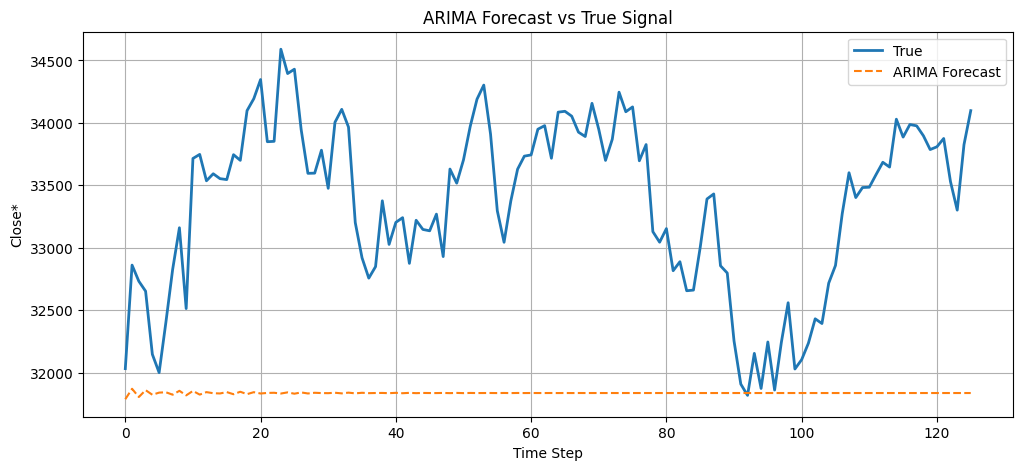

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(test_series.values, label='True', linewidth=2)
plt.plot(forecast_arima.values, label='ARIMA Forecast', linestyle='--')
plt.title("ARIMA Forecast vs True Signal")
plt.xlabel("Time Step")
plt.ylabel("Close*")
plt.legend()
plt.grid(True)
plt.show()

Phase 4 – Step 2: LSTM Baseline (Sequence-to-One Forecasting)

Goal:

Predict the next timestep’s value using a lag window (same as X_input → Y_target from Koopman phases).

Prepare PyTorch Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesLSTM(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].unsqueeze(-1), self.Y[idx]  #  (lag, 1)


# Use same trimmed X and Y from Phase 1
dataset = TimeSeriesLSTM(X_input[:-1], Y_target[:-1])
loader = DataLoader(dataset, batch_size=64, shuffle=True)

Define LSTM Model

In [ ]:
class LSTMForecaster(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)  # x: (batch, 1, lag)
        out = out[:, -1, :]    # get last hidden state
        return self.linear(out).squeeze(-1)  # predict single value

Train LSTM

In [ ]:
model_lstm = LSTMForecaster().to(device)
optimizer = optim.Adam(model_lstm.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

losses_lstm = []

for epoch in range(100):
    model_lstm.train()
    total_loss = 0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch[:, -1].to(device)  # only predict final step

        optimizer.zero_grad()
        y_pred = model_lstm(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    losses_lstm.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}: Loss = {avg_loss:.6f}")

Epoch 000: Loss = 0.777207
Epoch 010: Loss = 0.018462
Epoch 020: Loss = 0.015285
Epoch 030: Loss = 0.011926
Epoch 040: Loss = 0.011047
Epoch 050: Loss = 0.011015
Epoch 060: Loss = 0.009593
Epoch 070: Loss = 0.008710
Epoch 080: Loss = 0.008526
Epoch 090: Loss = 0.008311


Visualize Loss

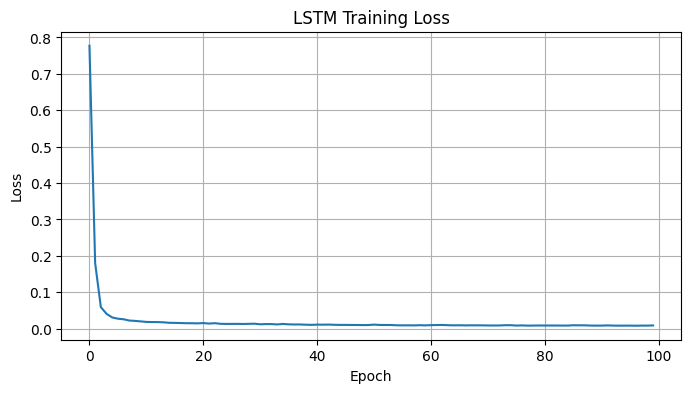

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(losses_lstm)
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Evaluate LSTM

In [ ]:
model_lstm.eval()
with torch.no_grad():
    X_all = torch.tensor(X_input[:-1], dtype=torch.float32).unsqueeze(-1).to(device)
    Y_true = Y_target[:-1][:, -1]  # predict last value in window
    Y_true = torch.tensor(Y_true, dtype=torch.float32).to(device)

    Y_pred = model_lstm(X_all)

# Compute RMSE
from sklearn.metrics import mean_squared_error
rmse_lstm = np.sqrt(mean_squared_error(Y_true.cpu().numpy(), Y_pred.cpu().numpy()))
print(f" LSTM RMSE: {rmse_lstm:.4f}")

 LSTM RMSE: 0.0896


Forecast Plot

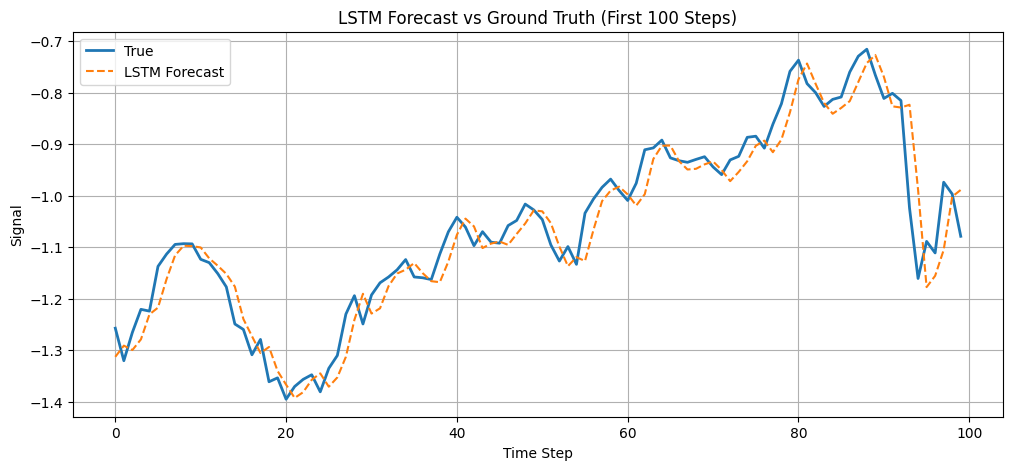

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(Y_true.cpu().numpy()[:100], label='True', linewidth=2)
plt.plot(Y_pred.cpu().numpy()[:100], label='LSTM Forecast', linestyle='--')
plt.title("LSTM Forecast vs Ground Truth (First 100 Steps)")
plt.xlabel("Time Step")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

Phase 4 – Step 3: Transformer Baseline (Sequence-to-One Forecasting)

Goal:

Use a Transformer encoder to predict the next value in the sequence, given a lagged input vector.

Define Dataset for Transformer

In [ ]:
class TransformerDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y[:, -1], dtype=torch.float32)  # predict last point

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].unsqueeze(1)  # shape: (seq_len, 1)
        return x, self.Y[idx]

transformer_dataset = TransformerDataset(X_input[:-1], Y_target[:-1])
transformer_loader = DataLoader(transformer_dataset, batch_size=64, shuffle=True)

Define Transformer Model

In [ ]:
class TransformerForecaster(nn.Module):
    def __init__(self, seq_len, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(1, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(seq_len * d_model, 1)

    def forward(self, x):  # x: (batch, seq_len, 1)
        x = self.embedding(x)                # (batch, seq_len, d_model)
        x = self.encoder(x)                  # (batch, seq_len, d_model)
        x = x.flatten(start_dim=1)           # (batch, seq_len*d_model)
        return self.fc(x).squeeze(-1)        # (batch,)

Train Transformer

In [ ]:
model_tf = TransformerForecaster(seq_len=X_input.shape[1]).to(device)
optimizer = torch.optim.Adam(model_tf.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

losses_tf = []

for epoch in range(100):
    model_tf.train()
    total_loss = 0
    for x_batch, y_batch in transformer_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model_tf(x_batch)
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(transformer_loader)
    losses_tf.append(avg_loss)
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}: Loss = {avg_loss:.6f}")

Epoch 000: Loss = 0.233774
Epoch 010: Loss = 0.022803
Epoch 020: Loss = 0.015999
Epoch 030: Loss = 0.016405
Epoch 040: Loss = 0.013015
Epoch 050: Loss = 0.013346
Epoch 060: Loss = 0.011368
Epoch 070: Loss = 0.009405
Epoch 080: Loss = 0.009011
Epoch 090: Loss = 0.010036


Plot Training Loss

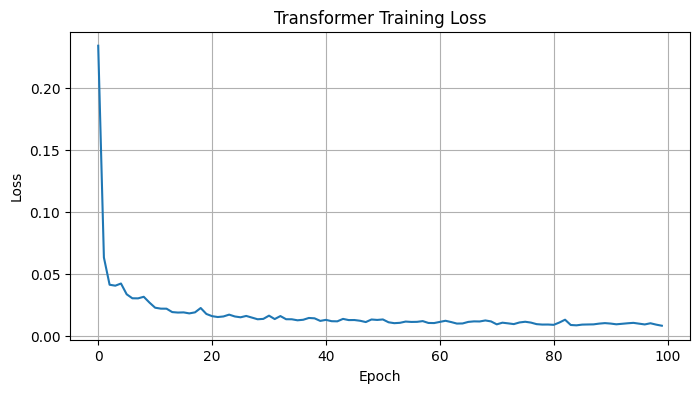

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(losses_tf)
plt.title("Transformer Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

Evaluate RMSE

In [ ]:
model_tf.eval()
with torch.no_grad():
    X_all_tf = torch.tensor(X_input[:-1], dtype=torch.float32).unsqueeze(-1).to(device)
    Y_true_tf = torch.tensor(Y_target[:-1][:, -1], dtype=torch.float32).to(device)
    Y_pred_tf = model_tf(X_all_tf)

rmse_tf = np.sqrt(mean_squared_error(Y_true_tf.cpu().numpy(), Y_pred_tf.cpu().numpy()))
print(f" Transformer RMSE: {rmse_tf:.4f}")

 Transformer RMSE: 0.0774


Forecast Visualization

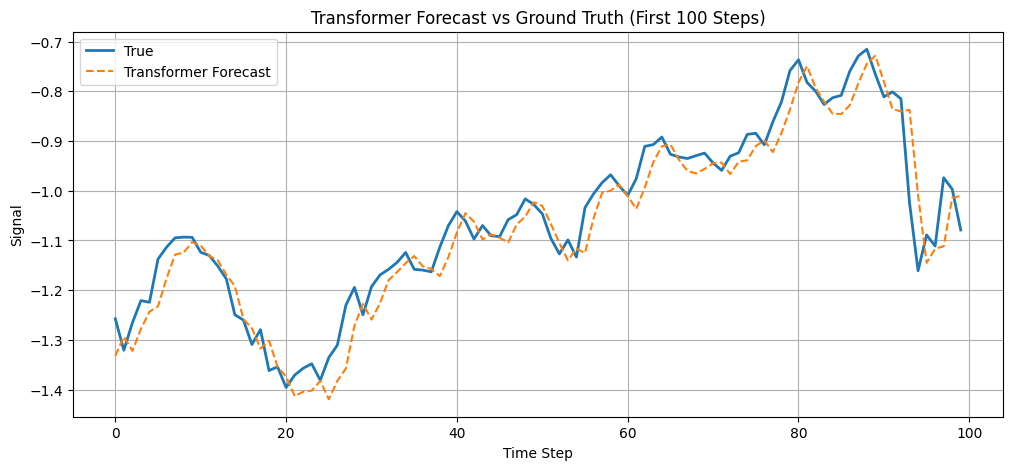

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(Y_true_tf.cpu().numpy()[:100], label='True', linewidth=2)
plt.plot(Y_pred_tf.cpu().numpy()[:100], label='Transformer Forecast', linestyle='--')
plt.title("Transformer Forecast vs Ground Truth (First 100 Steps)")
plt.xlabel("Time Step")
plt.ylabel("Signal")
plt.legend()
plt.grid(True)
plt.show()

Phase 5: Summary & Visualization Dashboard

RMSE Bar Plot

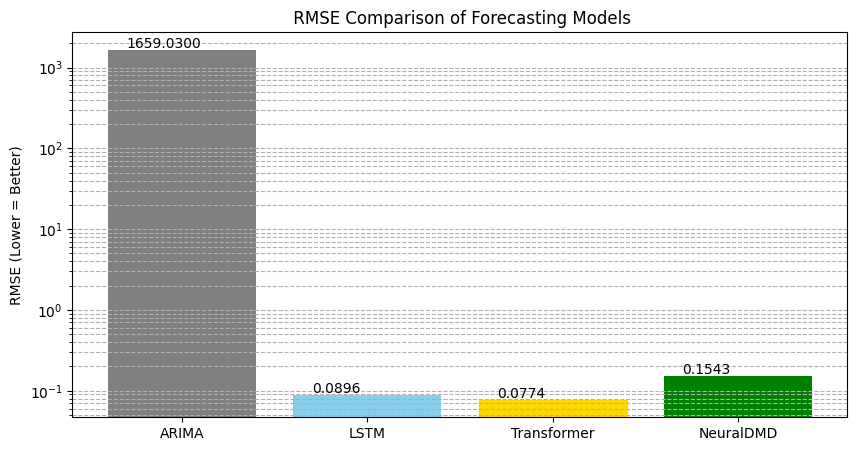

In [ ]:
import matplotlib.pyplot as plt

models = ['ARIMA', 'LSTM', 'Transformer', 'NeuralDMD']
rmse_scores = [1659.03, 0.0896, 0.0774, 0.1543]

plt.figure(figsize=(10, 5))
bars = plt.bar(models, rmse_scores, color=['gray', 'skyblue', 'orange', 'green'])
bars[2].set_color('gold')  # highlight best

plt.ylabel("RMSE (Lower = Better)")
plt.title(" RMSE Comparison of Forecasting Models")
plt.yscale('log')  # to visualize ARIMA outlier
plt.grid(True, which="both", axis="y", linestyle='--')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.1, yval * 1.05, f"{yval:.4f}", fontsize=10)

plt.show()